<a href="https://colab.research.google.com/github/AnweshaC21/ASL-Sign-Recognition/blob/main/EfficientNet_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q kaggle
# !pip install -U keras-efficientnet-v2 -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from sklearn.model_selection import train_test_split
# import keras_efficientnet_v2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Getting the data

In [ ]:
# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download lexset/synthetic-asl-alphabet

In [ ]:
# !unzip -qq "synthetic-asl-alphabet.zip" -d "synthetic-asl-alphabet"

In [ ]:
train_dir = '/kaggle/input/alphabets-cnn/Alphabets_CNN_data/train'
test_dir = '/kaggle/input/alphabets-cnn/Alphabets_CNN_data/test'

In [ ]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)

    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [ ]:
train_df.sample(5)

,filename,label
10602,Q/14aca3aa-f37a-4883-b9ce-70f09c3e8599-rgb_000...,Q
13438,G/024df437-e53b-459f-ba39-78976210e06f-rgb_000...,G
3402,I/40e12dcf-5659-4665-aa75-ebb421cab605-rgb_000...,I
9007,K/20801eee-84a9-4b43-bf30-29c4f882b64d-rgb_000...,K
22196,D/517e8581-06ed-45b5-93de-87e1a85dd09d-rgb_000...,D


# Split train-valid

In [ ]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.11111)
print(X_train.shape)
print(X_valid.shape)

(20800,)
(2600,)


In [ ]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [ ]:
train['label'].value_counts()

V    800
A    800
W    800
S    800
E    800
P    800
B    800
K    800
T    800
R    800
M    800
F    800
H    800
C    800
L    800
G    800
J    800
U    800
D    800
N    800
I    800
Z    800
O    800
Q    800
X    800
Y    800
Name: label, dtype: int64

In [ ]:
valid['label'].value_counts()

Q    100
E    100
F    100
W    100
A    100
J    100
D    100
L    100
B    100
R    100
K    100
N    100
G    100
X    100
Z    100
Y    100
V    100
U    100
M    100
I    100
H    100
C    100
T    100
S    100
O    100
P    100
Name: label, dtype: int64

In [ ]:
test['label'].value_counts()

N    100
R    100
D    100
W    100
L    100
P    100
C    100
Z    100
V    100
T    100
O    100
A    100
G    100
S    100
Y    100
Q    100
K    100
X    100
M    100
U    100
E    100
H    100
F    100
I    100
B    100
J    100
Name: label, dtype: int64

In [ ]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 20800 validated image filenames belonging to 26 classes.
Found 2600 validated image filenames belonging to 26 classes.
Found 2600 validated image filenames.


# EfficientNetV2B0

## Training

In [ ]:
tf.keras.backend.clear_session()
num_classes = 26

backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='inputs')
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# x = Dense(100, activation='relu')(x)
outputs = Dense(26, activation='softmax')(x)

model_efficientnet = tf.keras.Model(inputs=inputs, outputs=outputs, name='efficientnet_model')
model_efficientnet.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                33306     
Total params: 4,082,877
Trainable params: 33,306
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()
num_classes = 26
model_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SIZE + (3,))


model_efficientnet = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dropout(0.2),
    Dense(num_classes, activation='softmax') # create our own output layer
])

model_efficientnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                33306     
Total params: 5,952,618
Trainable params: 33,306
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
model_efficientnet.compile(optimizer=keras.optimizers.Adam(),
                           loss='sparse_categorical_crossentropy',
                           metrics=["accuracy"])

In [ ]:
cb = [
#     callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('model_efficientnet.hdf5', save_best_only=True, monitor='val_loss')
]

history_efficientnet = model_efficientnet.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 30,
    batch_size = 32,
    verbose = 1,
    callbacks = cb
)

Epoch 1/30
650/650 [==============================] - 443s 660ms/step - loss: 1.1415 - accuracy: 0.7711 - val_loss: 0.5082 - val_accuracy: 0.9192
Epoch 2/30
650/650 [==============================] - 286s 441ms/step - loss: 0.3923 - accuracy: 0.9320 - val_loss: 0.2936 - val_accuracy: 0.9508
Epoch 3/30
650/650 [==============================] - 282s 434ms/step - loss: 0.2595 - accuracy: 0.9528 - val_loss: 0.2115 - val_accuracy: 0.9635
Epoch 4/30
650/650 [==============================] - 281s 433ms/step - loss: 0.1979 - accuracy: 0.9643 - val_loss: 0.1676 - val_accuracy: 0.9700
Epoch 5/30
650/650 [==============================] - 283s 435ms/step - loss: 0.1645 - accuracy: 0.9674 - val_loss: 0.1446 - val_accuracy: 0.9719
Epoch 6/30
650/650 [==============================] - 286s 441ms/step - loss: 0.1409 - accuracy: 0.9728 - val_loss: 0.1283 - val_accuracy: 0.9781
Epoch 7/30
650/650 [==============================] - 285s 438ms/step - loss: 0.1214 - accuracy: 0.9767 - val_loss: 0.1103 -

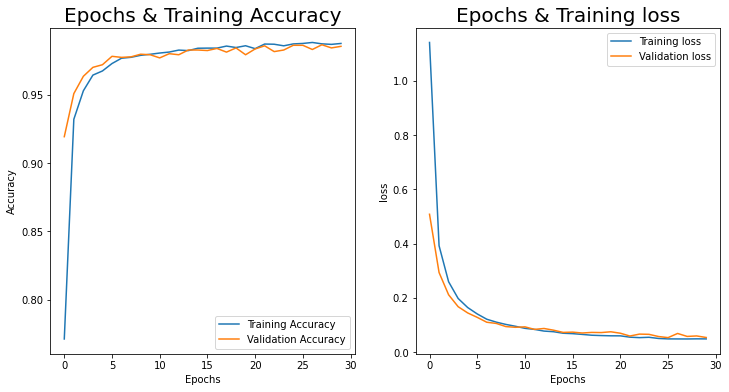

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_efficientnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_efficientnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_efficientnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_efficientnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [ ]:
model_loaded = model_efficientnet

In [ ]:
test_generator.reset()
pred = model_loaded.predict(test_generator, verbose=1)

2600/2600 [==============================] - 36s 13ms/step


In [ ]:
pred = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(accuracy_score(test['label'], pred))
print(classification_report(test['label'], pred))

0.9923076923076923
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      0.97      0.98       100
           D       0.99      0.98      0.98       100
           E       0.98      1.00      0.99       100
           F       0.97      1.00      0.99       100
           G       0.99      1.00      1.00       100
           H       0.99      1.00      1.00       100
           I       0.98      0.99      0.99       100
           J       1.00      0.99      0.99       100
           K       1.00      0.99      0.99       100
           L       0.99      1.00      1.00       100
           M       1.00      0.99      0.99       100
           N       0.99      0.99      0.99       100
           O       1.00      1.00      1.00       100
           P       0.99      0.98      0.98       100
           Q       0.99      0.99      0.99       100
        

## Fine-tuning

In [ ]:
feature_extractor_layer.trainable = True

model_efficientnet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                           loss='sparse_categorical_crossentropy',
                           metrics=["accuracy"])

In [ ]:
cb = [
#     callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('model_efficientnet_finetuned.hdf5', save_best_only=True, monitor='val_loss')
]

train_generator.reset()
valid_generator.reset()

history_efficientnet_2 = model_efficientnet.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    batch_size = 32,
    verbose = 1,
    callbacks = cb
)

Epoch 1/10
650/650 [==============================] - 318s 471ms/step - loss: 0.8232 - accuracy: 0.7713 - val_loss: 0.0909 - val_accuracy: 0.9712
Epoch 2/10
650/650 [==============================] - 302s 465ms/step - loss: 0.2336 - accuracy: 0.9277 - val_loss: 0.0380 - val_accuracy: 0.9927
Epoch 3/10
650/650 [==============================] - 302s 465ms/step - loss: 0.1106 - accuracy: 0.9668 - val_loss: 0.0266 - val_accuracy: 0.9938
Epoch 4/10
650/650 [==============================] - 298s 458ms/step - loss: 0.0672 - accuracy: 0.9809 - val_loss: 0.0246 - val_accuracy: 0.9962
Epoch 5/10
650/650 [==============================] - 298s 459ms/step - loss: 0.0445 - accuracy: 0.9885 - val_loss: 0.0206 - val_accuracy: 0.9965
Epoch 6/10
650/650 [==============================] - 300s 461ms/step - loss: 0.0354 - accuracy: 0.9910 - val_loss: 0.0195 - val_accuracy: 0.9973
Epoch 7/10
650/650 [==============================] - 307s 472ms/step - loss: 0.0328 - accuracy: 0.9920 - val_loss: 0.0206 -

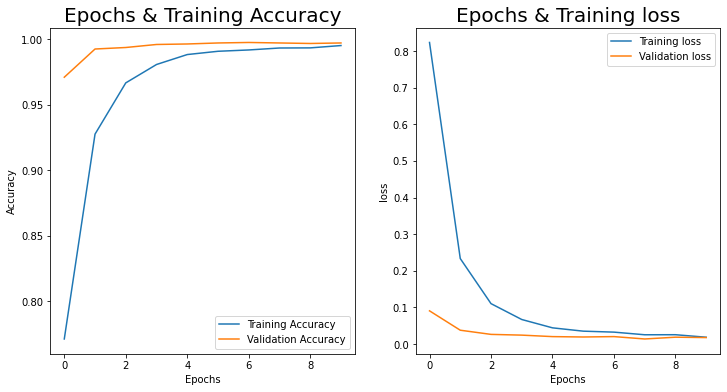

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_efficientnet_2.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_efficientnet_2.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_efficientnet_2.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_efficientnet_2.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [ ]:
model_loaded = model_efficientnet

In [ ]:
test_generator.reset()
pred = model_loaded.predict(test_generator, verbose=1)

2600/2600 [==============================] - 34s 13ms/step


In [ ]:
pred = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(accuracy_score(test['label'], pred))
print(classification_report(test['label'], pred))

0.9996153846153846
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00       100
           O       1.00      1.00      1.00       100
           P       1.00      0.99      0.99       100
           Q       0.99      1.00      1.00       100
        